In [171]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


In [86]:
# load a csv called data.csv with the separation character ','

geo_data = pd.read_csv('raw_data/geo_eth.csv', sep=',')
cons_data = pd.read_csv('raw_data/cons_eth.csv', sep=',')

In [87]:
geo_data.shape

(4954, 42)

In [47]:
cons_data.head()

,household_id,household_id2,ea_id,ea_id2,saq01,rural,pw_w3,adulteq,hh_size,no_conv,no_cons,food_cons_ann,nonfood_cons_ann,educ_cons_ann,total_cons_ann,price_index_hce,nom_totcons_aeq,cons_quint
0,1010101601002,10101088801601002,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,1970.800049,1013.0,0.0,2983.800049,1.034,4032.162109,2.0
1,1010101601017,10101088801601017,1010101601,10101088801601,1,1,2897.155029,7.21,9,0,0,7883.200195,5337.0,358.0,13578.200195,1.034,1883.245483,1.0
2,1010101601034,10101088801601034,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,8958.444458,322.0,0.0,9280.444336,1.034,12541.140625,5.0
3,1010101601049,10101088801601049,1010101601,10101088801601,1,1,2897.155029,2.50,3,0,0,9594.000000,1630.0,480.0,11704.000000,1.034,4681.600098,3.0
4,1010101601064,10101088801601064,1010101601,10101088801601,1,1,2897.155029,1.58,2,0,0,11702.888916,3272.0,0.0,14974.888672,1.034,9477.778320,5.0


In [48]:

COUNTRIES_DIR = os.path.join("..", 'data', 'countries')

In [49]:
def process_ethiopia():

    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household

    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
    
    # for file in [consumption_file, geovariables_file]:
    #     assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df = cons_data
    df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
    df['pph'] = df[hhsize_col]
    df['cons_ph'] = df['cons_ph'] / ppp / 365
    df = df[['household_id2', 'cons_ph', 'pph']]

    df_geo = geo_data
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
  
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [50]:
data = process_ethiopia()

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_87404/1253664893.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


In [269]:
data['nightlights'] = data['nightlights'].astype('float64')

In [274]:
data

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,3.455701,39.515994,14.854634,0.0
1,eth,3.549937,39.184234,14.312022,0.0
2,eth,3.864243,39.101366,12.470145,0.0
3,eth,3.982931,38.491368,8.336539,0.0
4,eth,4.048194,41.930928,4.762526,0.0
...,...,...,...,...,...
518,eth,14.288590,38.210252,13.926005,0.0
519,eth,14.300796,39.059489,6.882396,0.0
520,eth,14.319217,39.271599,5.894326,0.0
521,eth,14.353816,37.890876,8.197660,0.0


In [250]:
RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [258]:
def drop_0s(df, fr=0.1):
    """
        Solves for d:
            (c_z - d)/(n - d) = fr
        Where d = rows to drop, c_z = num rows with zero nightlights, n = num rows, fr = frac remaining
        
        Yields:
        d = (c_z - n*fr) / (1 - fr)
    """
    np.random.seed(RANDOM_SEED)
    c_z = (df['nightlights']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['nightlights']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    # this is how you do it purely randomly but some clusters might get wiped out
    # z_inds = np.argwhere(df['nightlights'].values == 0).reshape(-1)
    # drop_inds = np.random.choice(z_inds, d, replace=False)
    return df.drop(drop_inds).reset_index(drop=True)

In [257]:
drop_0s(data)

dropping: 371
Need to drop 0 per cluster with 0 nightlights
dropping too many in 3.45570056699, 39.5159939261


AssertionError: None

In [255]:
def drop_in_range(df, lower=0, upper=2, fr=0.25):
    """
        Very similar to drop_0s calculation, but more generalized. Lower and upper are inclusive.
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)

In [256]:
drop_in_range(data)

dropping: 423
Need to drop 0 per cluster in the given range
dropping too many in 3.45570056699, 39.5159939261


AssertionError: None

In [71]:
import math
def create_space(lat, lon, s=1):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v

In [72]:
import rasterio

url_image = "raw_data/picture.tif"
with rasterio.open(url_image) as src:
    image_data = src.read(1)  
    transform = src.transform
    tif_array = np.squeeze(image_data)

    print(tif_array.shape)

(18000, 28800)


In [73]:
def custom_rasterio_open( min_lon, min_lat):
    xminPixel, ymaxPixel = ~transform * (min_lon, min_lat)

    xminPixel, ymaxPixel = int(xminPixel), int(ymaxPixel)
    
    return xminPixel, ymaxPixel

In [77]:
def add_nightlights(df, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = custom_rasterio_open(min_lon, min_lat)
        xmaxPixel, yminPixel = custom_rasterio_open(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    df['nightlights'] = cluster_nightlights

In [267]:
data['cons_pc'].describe()

count    523.000000
mean       9.888373
std        5.889993
min        1.598231
25%        6.078859
50%        8.661763
75%       12.383713
max       68.553522
Name: cons_pc, dtype: float64

In [263]:
add_nightlights(data, tif_array)

In [264]:
data['nightlights'].value_counts()

nightlights
0.000000    387
5.423706      2
0.099446      1
0.438061      1
1.467288      1
           ... 
1.198396      1
1.213367      1
0.869634      1
2.146259      1
2.939054      1
Name: count, Length: 136, dtype: int64

In [94]:
X = data[['nightlights']]
y = data['cons_pc']

In [90]:
X_non_zero = X[X != 0]

In [91]:
X_non_zero

23     0.035953
24     0.053930
31     0.226722
32     0.178416
36     9.478632
         ...   
506    1.018144
507    8.458162
510    5.779657
513    0.477778
516    2.939054
Name: nightlights, Length: 136, dtype: float32

<Axes: xlabel='nightlights', ylabel='Count'>

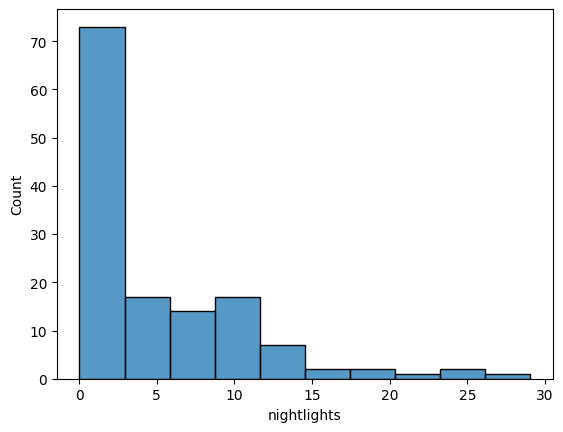

In [105]:
sns.histplot(X_non_zero)

<Axes: xlabel='nightlights', ylabel='cons_pc'>

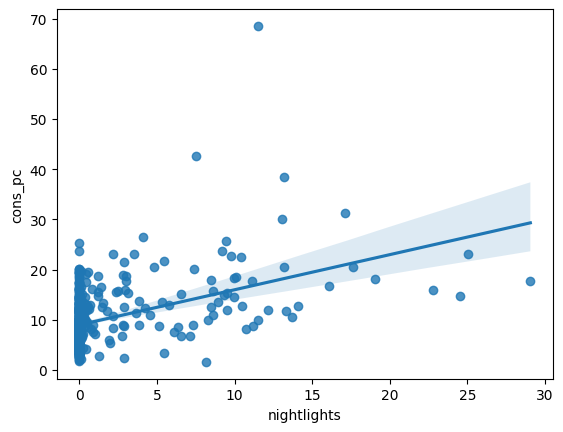

In [108]:
sns.regplot(x=X,y=y)

In [95]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [100]:
X_scaled = pd.DataFrame(X_scaled)

In [116]:
model = LinearRegression()
k_folds = KFold(n_splits=5)
scores = cross_val_score(model, X_scaled, y, cv = k_folds)
scores  

0.032343327616313935

In [154]:
scores

array([ 2.13625223e-01,  2.12959218e-04, -2.33696339e-01,  9.29250013e-02,
        8.86497942e-02])

In [121]:
data_Xy = data[['nightlights','cons_pc']]

In [123]:
data_Xy['nightlights'] = scaler.fit_transform(X)

/var/folders/78/kf_z610d5vvb7ch9l49_lghh0000gn/T/ipykernel_87404/3084886050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Xy['nightlights'] = scaler.fit_transform(X)


In [151]:
data_Xy.head()

,nightlights,cons_pc
0,0.0,14.854634
1,0.0,14.312022
2,0.0,12.470145
3,0.0,8.336539
4,0.0,4.762526


In [162]:
data_Xy.corr()

,nightlights,cons_pc
nightlights,1.000000,0.440152
cons_pc,0.440152,1.000000


In [229]:
#K-fold CV without data leakage
def k_fold_cv(df):
    #isolate nightlights and cons_pc columns
    df = df[['nightlights','cons_pc']]
    
    #train test split
    train_data, test_data = train_test_split(df, test_size=0.3)

    #define scaler
    scaler = MinMaxScaler()
    
    # Ready X's and y's
    X_train = pd.DataFrame(scaler.fit_transform(train_data[['nightlights']]))
    y_train = train_data['cons_pc']

    X_test = pd.DataFrame(scaler.fit_transform(test_data[['nightlights']]))
    y_test = test_data['cons_pc']
    n_split = 5
    len_split = int(df.shape[0]/n_split)

    # Initialize the 1st fold
    scores = []
    start = 0
    stop = len_split

    # Start the n-split fold CV
    for k in range(n_split): # k in [0,1,2,3,4]
        data_val = df.iloc[start:stop, :]
        data_train = df.drop(index=data_val.index)
        y_train = data_train['cons_pc']
        X_train = data_train.drop(columns=['cons_pc'])
        y_val = data_val['cons_pc']
        X_val = data_val.drop(columns=['cons_pc'])
        
        #fit model
        model_k =  LinearRegression()
        model_k.fit(X_train, y_train)
        
        #append score to scores list
        scores.append(model_k.score(X_val, y_val))
        
        # Setup next fold
        start = stop
        stop += len_split

    # Display the mean score and the scores standard deviation
    print(np.array(scores).mean())
    print(np.array(scores).std())

In [230]:
k_fold_cv(data_Xy)

0.03723239805532743
0.14092490524978635


In [161]:
addis_ab_df = data[
    (data['cluster_lat'] >= 8.9) & (data['cluster_lat'] <= 9.1) &
    (data['cluster_lon'] >= 38.7) & (data['cluster_lon'] <= 38.9)
]

In [188]:
#Get co-ords for city boundaries of next 10 most populous cities

dire_dawa_df = data[
    (data['cluster_lat'] >= 9.57) & (data['cluster_lat'] <= 9.64) &
    (data['cluster_lon'] >= 41.8) & (data['cluster_lon'] <= 41.9)
]
mekelle_df = data[
    (data['cluster_lat'] >= 13.45) & (data['cluster_lat'] <= 13.53) &
    (data['cluster_lon'] >= 39.4) & (data['cluster_lon'] <= 39.5)
]
adama_df = data[
    (data['cluster_lat'] >= 8.49) & (data['cluster_lat'] <= 8.59) &
    (data['cluster_lon'] >= 39.2) & (data['cluster_lon'] <= 39.3)
]
awassa_df = data[
    (data['cluster_lat'] >= 7.0) & (data['cluster_lat'] <= 7.11) &
    (data['cluster_lon'] >= 38.46) & (data['cluster_lon'] <= 38.53)
]
bahir_dar_df = data[
    (data['cluster_lat'] >= 11.53) & (data['cluster_lat'] <= 11.63) &
    (data['cluster_lon'] >= 37.3) & (data['cluster_lon'] <= 37.47)
]
gonder_df = data[
    (data['cluster_lat'] >= 12.57) & (data['cluster_lat'] <= 12.63) &
    (data['cluster_lon'] >= 37.43) & (data['cluster_lon'] <= 37.485)
]
dessie_df = data[
    (data['cluster_lat'] >= 11.09) & (data['cluster_lat'] <= 11.17) &
    (data['cluster_lon'] >= 39.61) & (data['cluster_lon'] <= 39.66)
]
jimma_df = data[
    (data['cluster_lat'] >= 7.65) & (data['cluster_lat'] <= 7.703) &
    (data['cluster_lon'] >= 36.8) & (data['cluster_lon'] <= 36.87)
]
jijiga_df = data[
    (data['cluster_lat'] >= 9.33) & (data['cluster_lat'] <= 9.374) &
    (data['cluster_lon'] >= 42.77) & (data['cluster_lon'] <= 42.823)
]
shashamane_df = data[
    (data['cluster_lat'] >= 7.16) & (data['cluster_lat'] <= 7.233) &
    (data['cluster_lon'] >= 38.56) & (data['cluster_lon'] <= 38.65)
]

In [204]:
second_eleventh_city_df = pd.concat([dire_dawa_df,mekelle_df,adama_df,awassa_df,bahir_dar_df,gonder_df,dessie_df,jimma_df,jijiga_df,shashamane_df],axis=0)

In [206]:
second_eleventh_city_df.reset_index(drop=True,inplace=True)

In [214]:
second_eleventh_city_df.head(3)

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,9.580849,41.852120,12.376362,4.236239
1,eth,9.592109,41.874382,22.719716,9.744740
2,eth,9.592166,41.888189,15.654187,2.486083


In [231]:
k_fold_cv(second_eleventh_city_df)

-0.588981007975664
0.6531055105716795


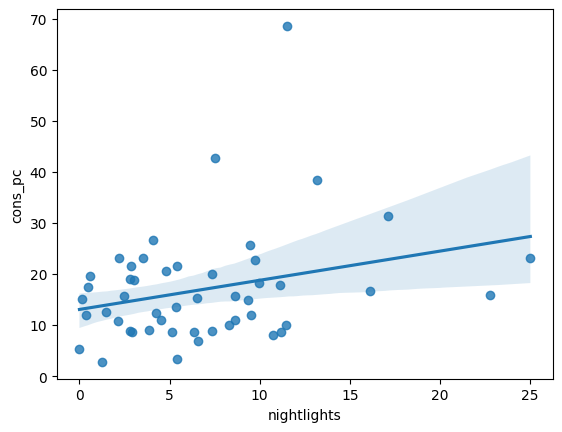

In [233]:
sns.regplot(x=second_eleventh_city_df[['nightlights']],y=second_eleventh_city_df['cons_pc']);

In [237]:
second_eleventh_city_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.00000,0.28132
nightlights,0.28132,1.00000


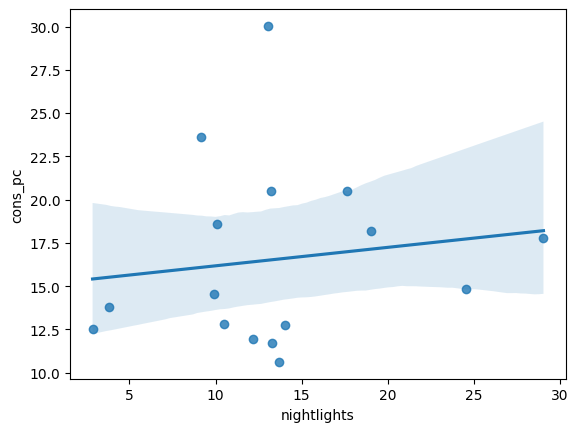

In [234]:
sns.regplot(x=addis_ab_df[['nightlights']],y=addis_ab_df['cons_pc']);

In [238]:
addis_ab_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.000000,0.136582
nightlights,0.136582,1.000000


In [241]:
all_cities_df = pd.concat([addis_ab_df,second_eleventh_city_df],axis=0)

In [243]:
all_cities_df.reset_index(drop=True,inplace=True)

In [244]:
all_cities_df

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,8.954261,38.776901,30.038594,13.032987
1,eth,8.957485,38.762128,10.622940,13.700825
2,eth,8.958031,38.748086,12.825229,10.469786
3,eth,8.964058,38.721902,20.488550,13.207790
4,eth,8.989751,38.773653,17.768381,29.061792
...,...,...,...,...,...
60,eth,7.668539,36.841583,17.821918,11.138804
61,eth,7.677240,36.817658,17.519095,0.447660
62,eth,9.368588,42.794475,23.115905,2.172655
63,eth,7.170938,38.601886,15.097178,0.148483


In [245]:
all_cities_df.drop(columns=['country','cluster_lat','cluster_lon']).corr()

,cons_pc,nightlights
cons_pc,1.000000,0.209461
nightlights,0.209461,1.000000


In [259]:
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=make_scorer(r2_score))

In [260]:
scores

array([-0.30721381, -1.9994647 , -0.01564321,  0.14171245,  0.12380885])